# TP2: Clasificación de Fashion-MNIST con PyTorch

## Trabajo Práctico 2 - Redes Neuronales 2025

### Referencias:
- https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
- https://github.com/zalandoresearch/fashion-mnist
- https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb



---

## Sección 1: Importación de Librerías



In [1]:
# Librerías estándar de Python
import os
import pickle
import datetime
from collections import defaultdict



In [2]:
# Librerías third party de Python
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import json



In [3]:
# Librerías de PyTorch
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose



---

## Sección 2: Configuración del Dispositivo (CPU/GPU)



In [4]:
# Detectar y configurar dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Dispositivo utilizado: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'CUDA Version: {torch.version.cuda}')



Dispositivo utilizado: cuda
GPU: NVIDIA GeForce RTX 3060
CUDA Version: 12.8


---

## Sección 3: Carga y Exploración del Dataset Fashion-MNIST

### 3.1: Descargar y cargar el dataset



In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normaliza de [0,1] a [-1,1]
])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)



### 3.2: Explorar el dataset



In [6]:
# Inspeccionar tamaño de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {len(train_set)}')
print(f'Tamaño del conjunto de validación: {len(valid_set)}')

# Ver un ejemplo
image, label = train_set[0]
print(f'\nDimensiones de la imagen: {image.shape}')
print(f'Etiqueta: {label}')
print(f'Tipo de datos: {type(image)}')



Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de validación: 10000

Dimensiones de la imagen: torch.Size([1, 28, 28])
Etiqueta: 9
Tipo de datos: <class 'torch.Tensor'>


In [7]:
# Diccionario de nombres de clases (según paper original)
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boots'
}

print('Clases de Fashion-MNIST:')
for idx, name in class_names.items():
    print(f'  {idx}: {name}')



Clases de Fashion-MNIST:
  0: T-shirt/top
  1: Trouser
  2: Pullover
  3: Dress
  4: Coat
  5: Sandal
  6: Shirt
  7: Sneaker
  8: Bag
  9: Ankle boots


### 3.3: Visualización inicial - Mosaico de imágenes



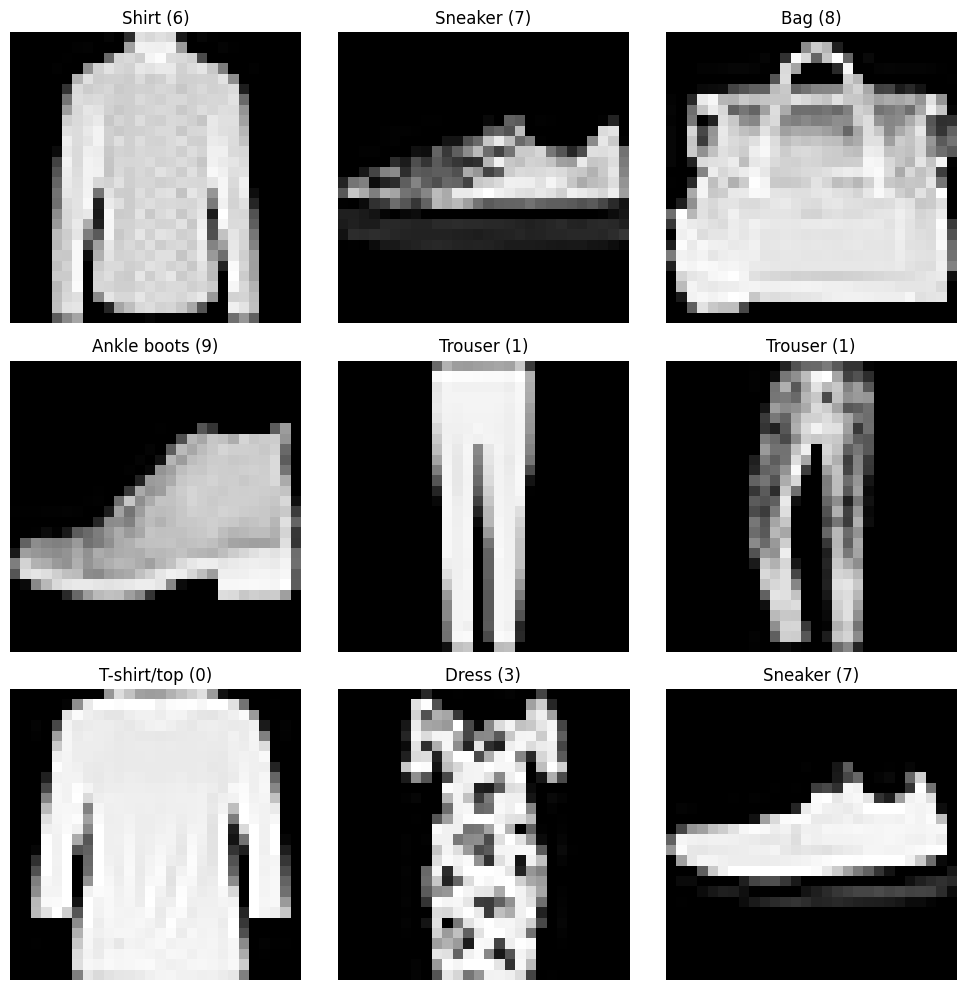

In [8]:
# Crear mosaico 3x3 de imágenes aleatorias
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()
    image, label = train_set[j]
    
    figure.add_subplot(rows, cols, i)
    plt.title(f'{class_names[label]} ({label})')
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="Greys_r")

plt.tight_layout()
plt.savefig('images/fashion_mnist_ejemplos.png', dpi=150, bbox_inches='tight')
plt.show()



---

## Sección 4: Definición de la Arquitectura de la Red Neuronal

### 4.1: Crear DataLoaders



In [9]:
# Crear DataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=100, shuffle=True)

# Explorar un batch
images, labels = next(iter(train_loader))
print(f'Dimensiones del batch de imágenes: {images.shape}')
print(f'Dimensiones del batch de etiquetas: {labels.shape}')



Dimensiones del batch de imágenes: torch.Size([100, 1, 28, 28])
Dimensiones del batch de etiquetas: torch.Size([100])


### 4.2: Definir la arquitectura de la red

Arquitectura:
- Capa de entrada: Flatten de 28×28 = 784 neuronas
- Capa oculta 1: 128 neuronas + ReLU + Dropout(0.2)
- Capa oculta 2: 64 neuronas + ReLU + Dropout(0.2)
- Capa de salida: 10 neuronas (sin activación, CrossEntropyLoss aplica softmax)



In [10]:
# Definir la red neuronal
class FashionMNIST_Net(nn.Module):
    def __init__(self):
        super(FashionMNIST_Net, self).__init__()
        # Capa de entrada: 28x28 = 784
        self.flatten = nn.Flatten()
        
        # Capas ocultas
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        # Capa de salida
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



### 4.3: Verificar la arquitectura



In [11]:
# Crear instancia del modelo y verificar
model = FashionMNIST_Net()
model.to(device)

# Probar con un batch de ejemplo
test_images, _ = next(iter(train_loader))
test_images = test_images.to(device)
output = model(test_images)

print(f'Dimensiones de entrada: {test_images.shape}')
print(f'Dimensiones de salida: {output.shape}')
print(f'Modelo en dispositivo: {next(model.parameters()).device}')



Dimensiones de entrada: torch.Size([100, 1, 28, 28])
Dimensiones de salida: torch.Size([100, 10])
Modelo en dispositivo: cuda:0


---

## Sección 5: Funciones de Entrenamiento y Validación



In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo por una época.
    
    Returns:
        train_loss: pérdida promedio de la época
        train_acc: precisión promedio de la época
    """
    model.train()  # Modo entrenamiento
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Mover datos al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calcular métricas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return train_loss, train_acc



In [13]:
def validate(model, valid_loader, criterion, device):
    """
    Evalúa el modelo sobre el conjunto de validación.
    
    Returns:
        val_loss: pérdida promedio
        val_acc: precisión promedio
    """
    model.eval()  # Modo evaluación
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            # Mover datos al dispositivo
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calcular métricas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(valid_loader)
    val_acc = 100 * correct / total
    
    return val_loss, val_acc



---

## Sección 6: Entrenamiento Básico

### 6.1: Configurar entrenamiento



In [18]:
# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Reinicializar modelo
model = FashionMNIST_Net()
model.to(device)

# Optimizador (debe crearse DESPUÉS de reinicializar el modelo)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f'Modelo configurado en: {device}')
print(f'Learning rate: {learning_rate}')
print(f'Optimizador: SGD')



Modelo configurado en: cuda
Learning rate: 0.001
Optimizador: SGD


### 6.2: Loop principal de entrenamiento



In [23]:
# Inicializar listas para guardar métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Número de épocas
num_epochs = 30

print(f'Iniciando entrenamiento por {num_epochs} épocas...')
print('-' * 60)

for epoch in range(num_epochs):
    # Entrenar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validar
    val_loss, val_acc = validate(model, valid_loader, criterion, device)
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Imprimir progreso
    print(f'Época [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)

print('Entrenamiento completado!')



Iniciando entrenamiento por 30 épocas...
------------------------------------------------------------
Época [1/30]
  Train Loss: 0.7293, Train Acc: 73.36%
  Val Loss: 0.6551, Val Acc: 75.79%
------------------------------------------------------------
Época [2/30]
  Train Loss: 0.7147, Train Acc: 73.78%
  Val Loss: 0.6445, Val Acc: 76.03%
------------------------------------------------------------
Época [3/30]
  Train Loss: 0.7038, Train Acc: 74.13%
  Val Loss: 0.6364, Val Acc: 76.26%
------------------------------------------------------------
Época [4/30]
  Train Loss: 0.6934, Train Acc: 74.60%
  Val Loss: 0.6280, Val Acc: 76.51%
------------------------------------------------------------
Época [5/30]
  Train Loss: 0.6846, Train Acc: 74.95%
  Val Loss: 0.6206, Val Acc: 76.85%
------------------------------------------------------------
Época [6/30]
  Train Loss: 0.6752, Train Acc: 75.28%
  Val Loss: 0.6135, Val Acc: 77.35%
-----------------------------------------------------------

---

## Sección 7: Visualización de Resultados Básicos

### 7.1: Gráficos de curvas de entrenamiento



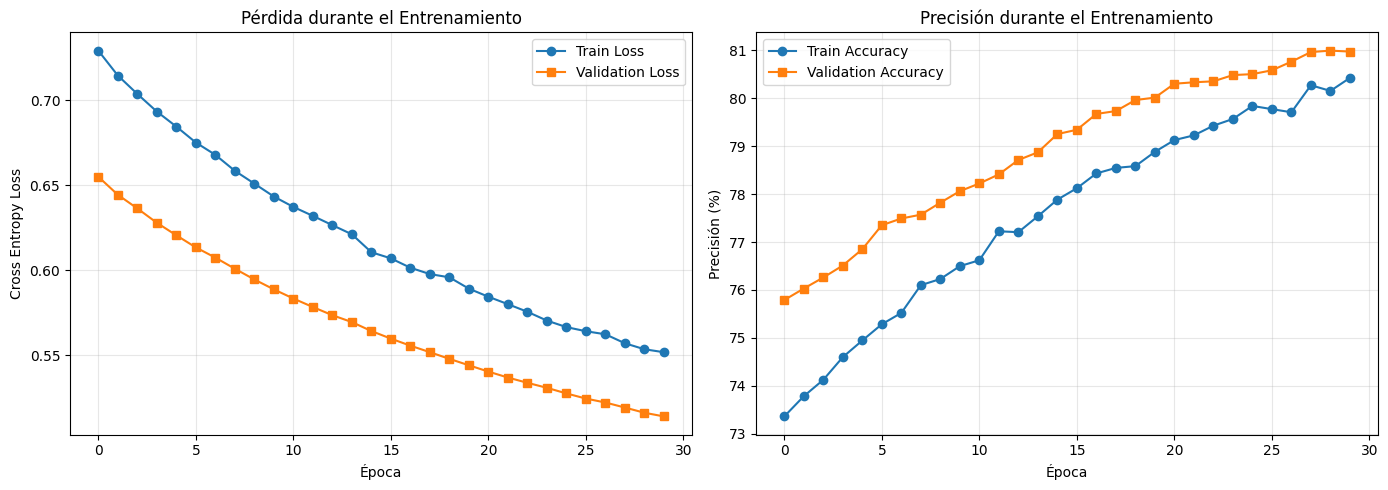

In [24]:
# Crear figura con curvas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Época')
ax1.set_ylabel('Cross Entropy Loss')
ax1.set_title('Pérdida durante el Entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de precisión
ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(val_accuracies, label='Validation Accuracy', marker='s')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión (%)')
ax2.set_title('Precisión durante el Entrenamiento')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/curvas_entrenamiento_basico.png', dpi=150, bbox_inches='tight')
plt.show()



ANÁLISIS DEL NÚMERO ÓPTIMO DE ÉPOCAS

Época con mejor precisión de validación: 29
  Precisión de validación: 80.99%
  Precisión de entrenamiento: 80.15%
  Diferencia: -0.84%

Época con menor pérdida de validación: 30
  Pérdida de validación: 0.5140
  Pérdida de entrenamiento: 0.5518

Análisis de las últimas 5 épocas:
  Mejora en precisión: 0.39%
  → La precisión se está estabilizando (posible convergencia)

RECOMENDACIÓN:
  El modelo está cerca de su óptimo. Épocas recomendadas: 29


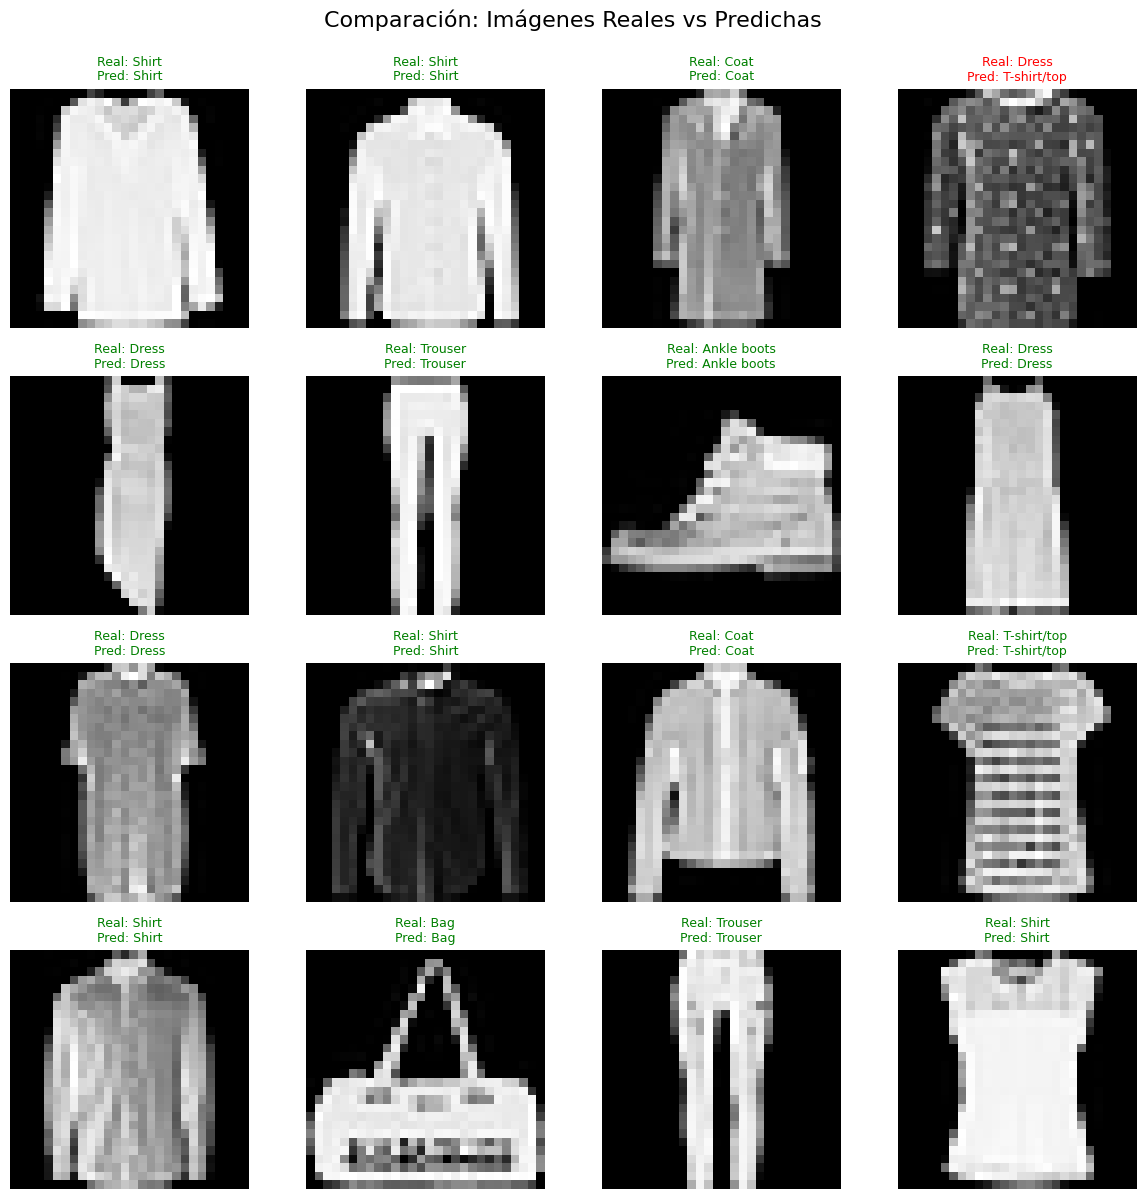


Estadísticas del batch mostrado:
  Total de imágenes: 16
  Predicciones correctas: 15
  Predicciones incorrectas: 1
  Precisión del batch: 93.75%


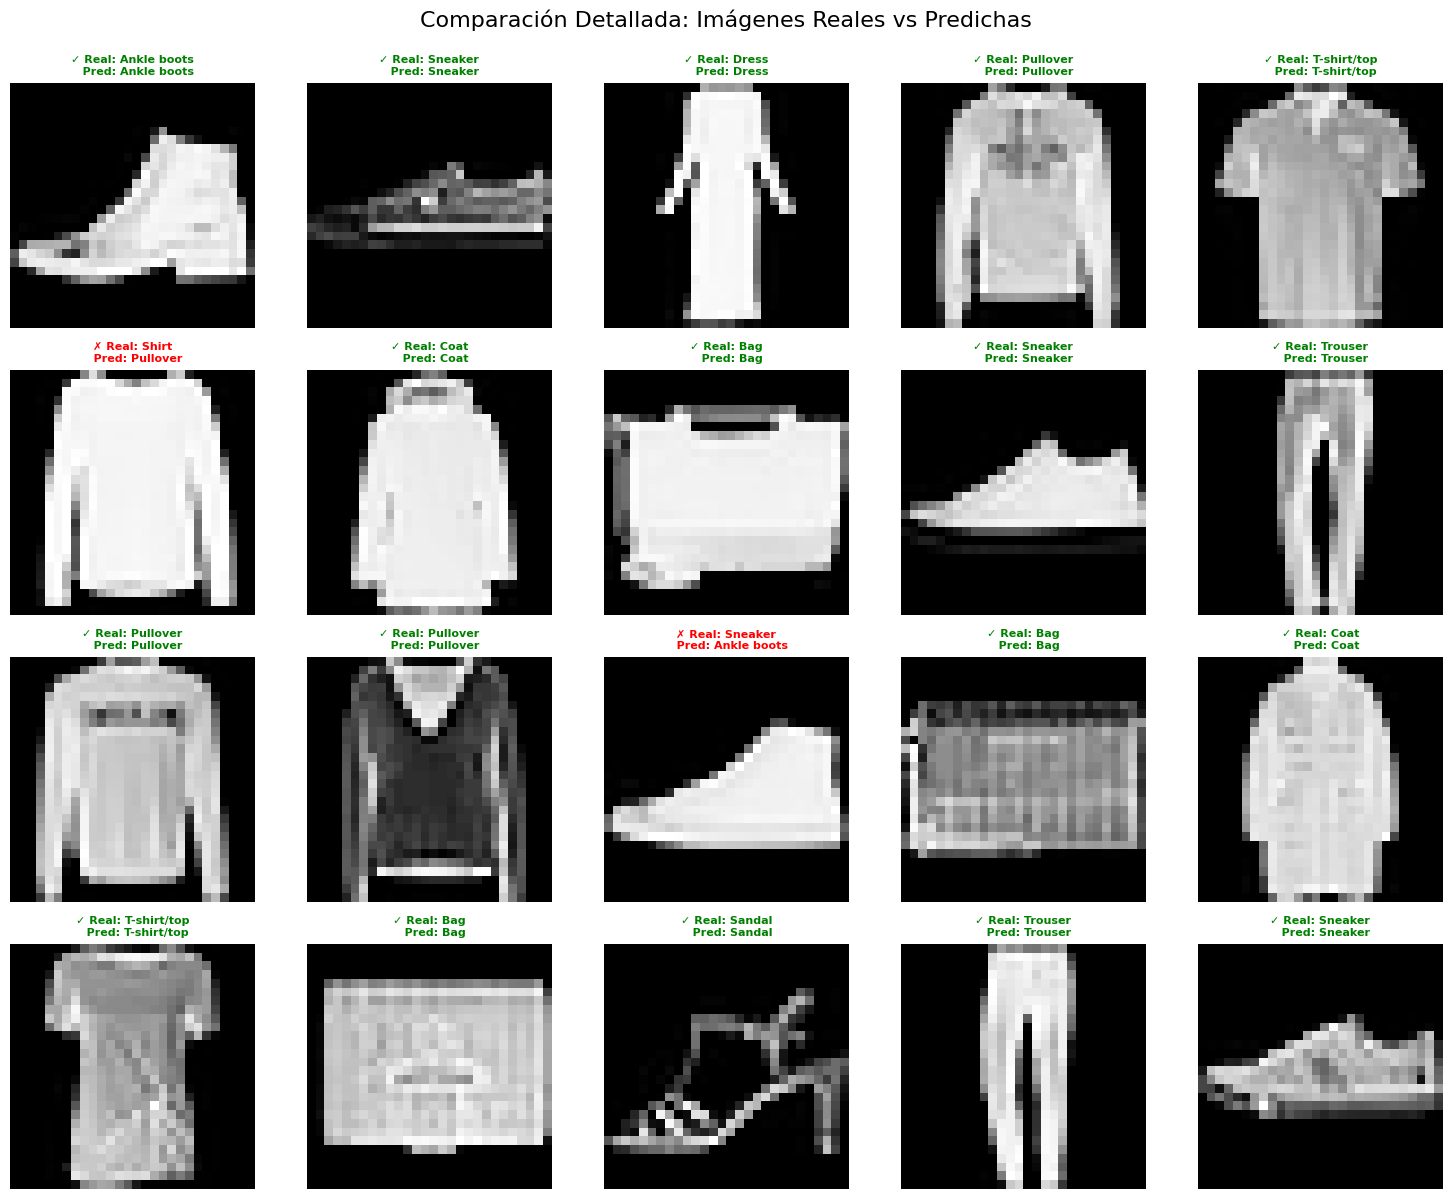

### 7.2: Matriz de confusión



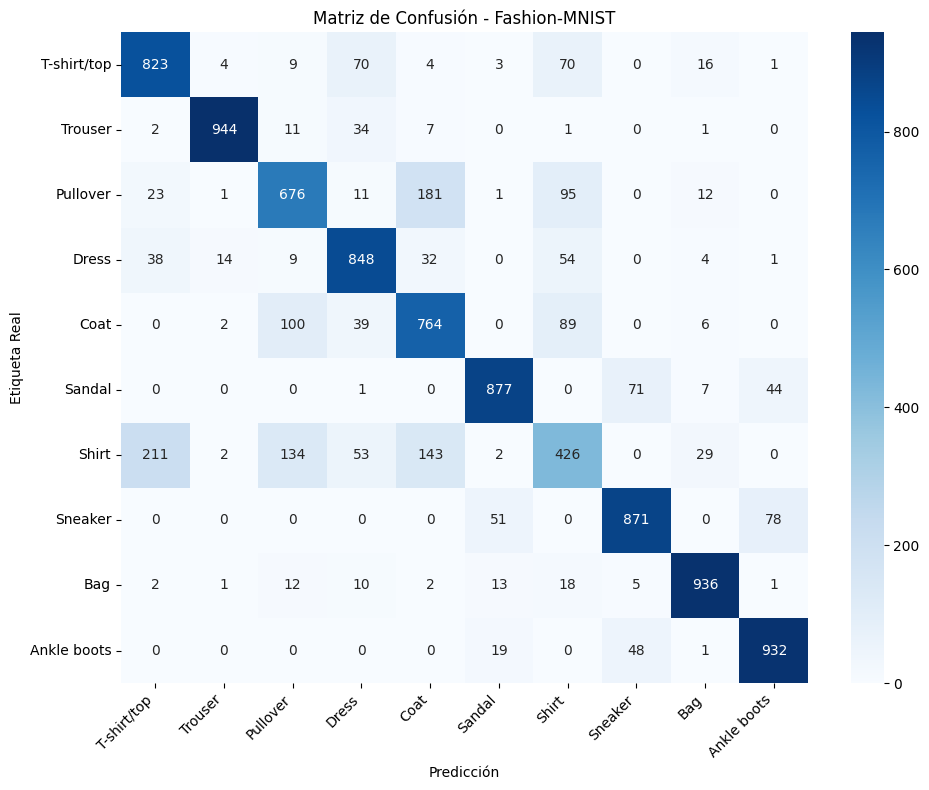

Precisión general en validación: 80.97%


In [26]:
# Obtener todas las predicciones del conjunto de validación
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_names[i] for i in range(10)],
            yticklabels=[class_names[i] for i in range(10)])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión - Fashion-MNIST')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('images/matriz_confusion_basico.png', dpi=150, bbox_inches='tight')
plt.show()

# Calcular precisión general
accuracy = accuracy_score(all_labels, all_preds)
print(f'Precisión general en validación: {accuracy*100:.2f}%')



---

## Sección 8: Análisis de Hiperparámetros



Entrenando con dropout = 0.0...
Final - Train Acc: 75.38%, Val Acc: 75.01%

Entrenando con dropout = 0.2...
Final - Train Acc: 68.22%, Val Acc: 73.55%

Entrenando con dropout = 0.4...
Final - Train Acc: 63.02%, Val Acc: 73.27%

Entrenando con dropout = 0.6...
Final - Train Acc: 52.67%, Val Acc: 69.63%


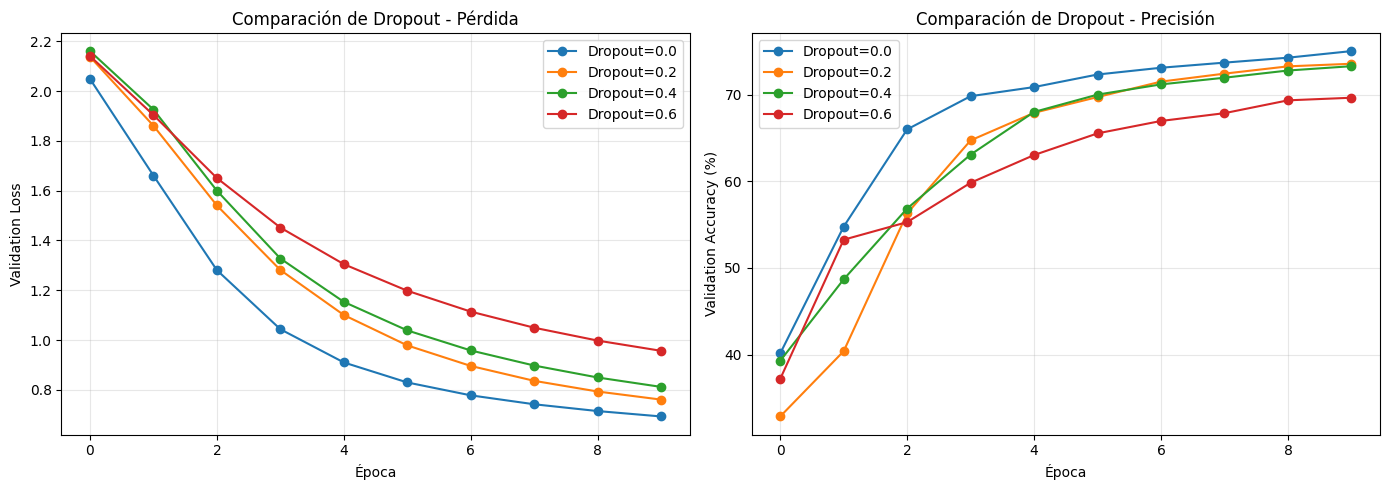


Entrenando con arquitectura 64-32...
Final - Train Acc: 64.98%, Val Acc: 72.79%

Entrenando con arquitectura 128-64...
Final - Train Acc: 68.16%, Val Acc: 73.66%

Entrenando con arquitectura 256-128...
Final - Train Acc: 71.49%, Val Acc: 73.93%

Entrenando con arquitectura 512-256...
Final - Train Acc: 73.24%, Val Acc: 75.06%


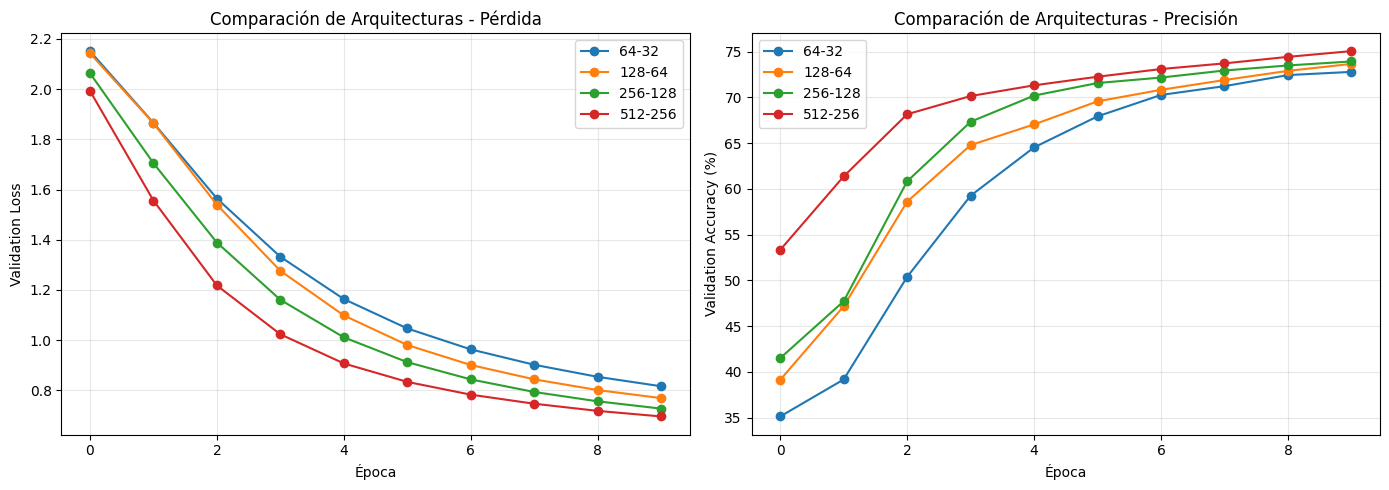


Entrenando por 5 épocas...
Final - Train Acc: 59.21%, Val Acc: 69.65%

Entrenando por 10 épocas...
Final - Train Acc: 69.32%, Val Acc: 74.28%

Entrenando por 15 épocas...
Final - Train Acc: 72.41%, Val Acc: 75.22%

Entrenando por 20 épocas...
Final - Train Acc: 75.23%, Val Acc: 77.62%

Entrenando por 30 épocas...
Final - Train Acc: 77.92%, Val Acc: 79.63%


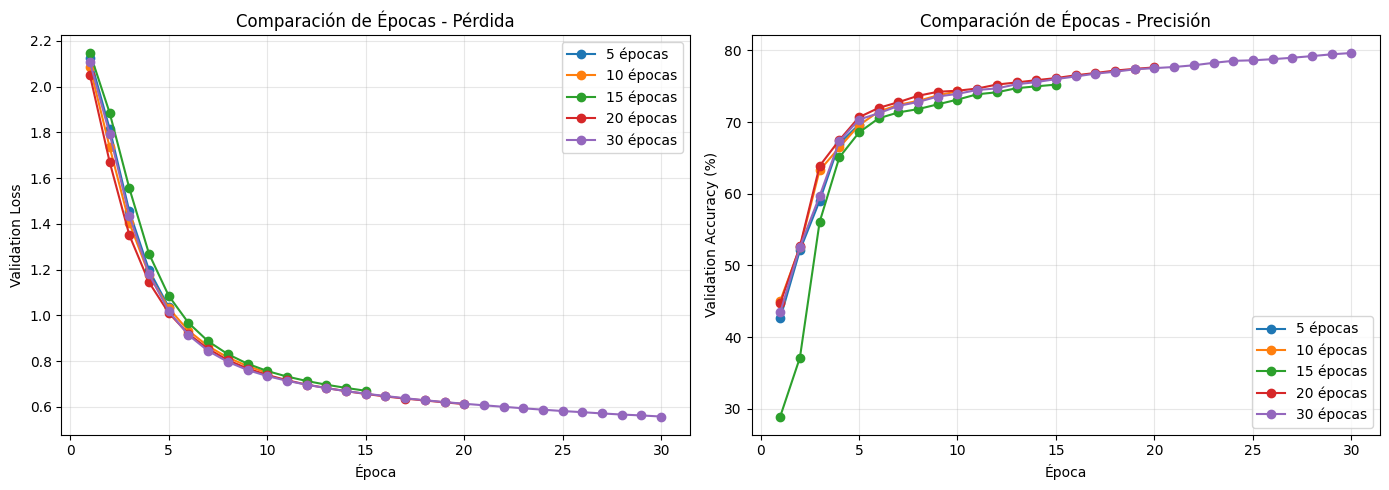


Entrenando con batch_size = 32...
Final - Train Acc: 77.72%, Val Acc: 79.35%

Entrenando con batch_size = 64...
Final - Train Acc: 72.78%, Val Acc: 75.84%

Entrenando con batch_size = 100...
Final - Train Acc: 68.80%, Val Acc: 72.85%

Entrenando con batch_size = 128...
Final - Train Acc: 67.08%, Val Acc: 72.86%

Entrenando con batch_size = 256...
Final - Train Acc: 51.80%, Val Acc: 61.74%


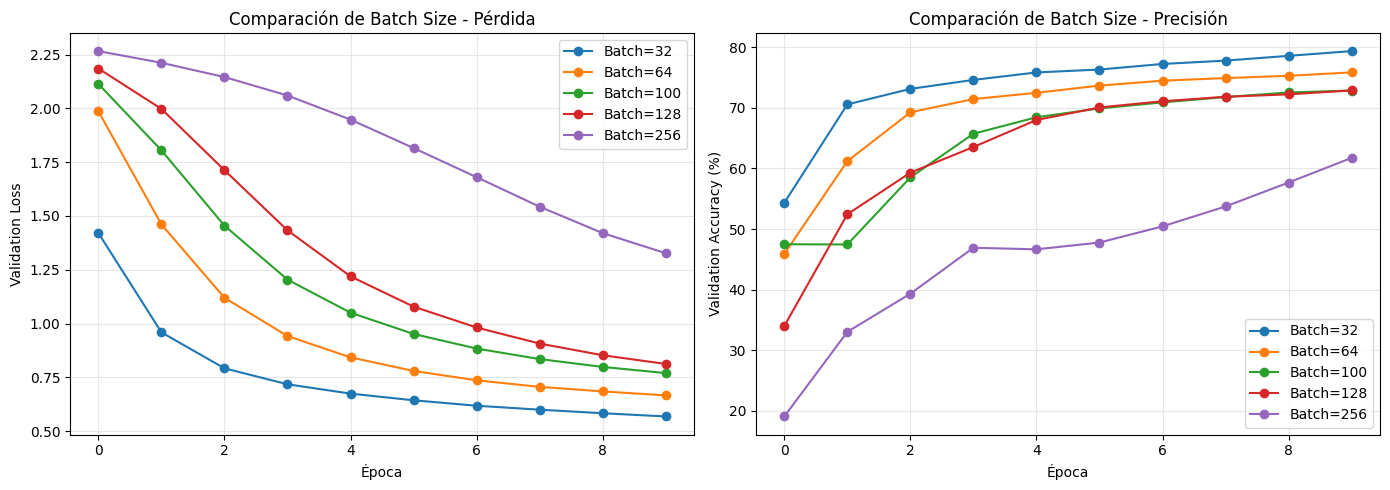

### 8.1: Variar Learning Rate


Entrenando con learning rate = 0.0001...
Final - Train Acc: 33.36%, Val Acc: 34.50%

Entrenando con learning rate = 0.001...
Final - Train Acc: 68.92%, Val Acc: 73.79%

Entrenando con learning rate = 0.01...
Final - Train Acc: 83.79%, Val Acc: 83.84%


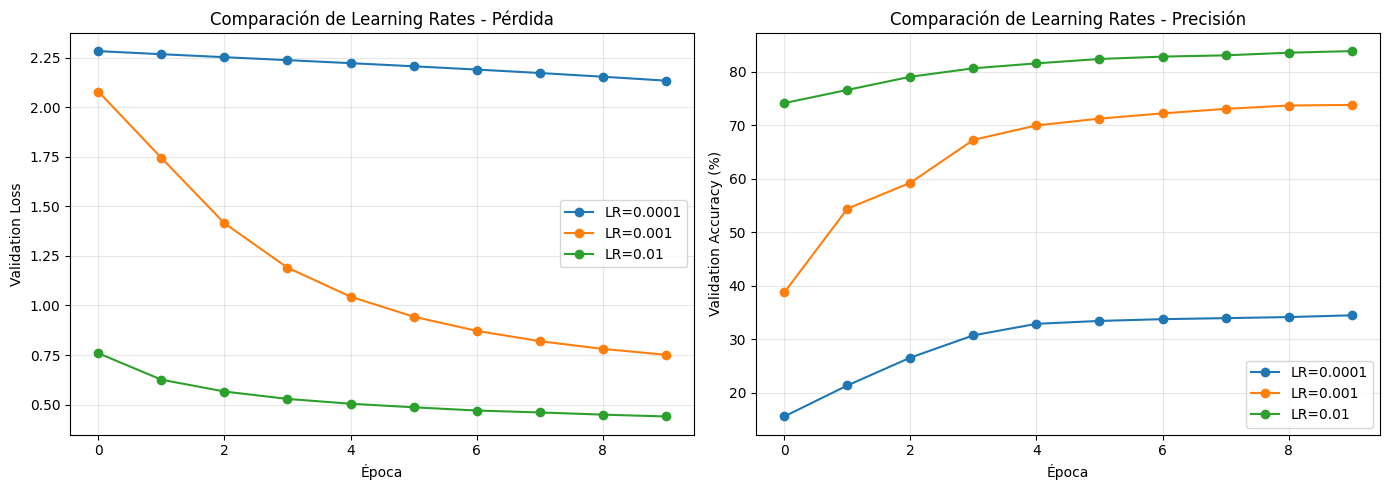

In [27]:
# Probar diferentes learning rates
learning_rates = [0.0001, 0.001, 0.01]
results_lr = {}

for lr in learning_rates:
    print(f'\nEntrenando con learning rate = {lr}...')
    
    # Reinicializar modelo
    model = FashionMNIST_Net()
    model.to(device)
    
    # Configurar optimizador
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Listas para métricas
    train_losses_lr = []
    val_losses_lr = []
    train_accs_lr = []
    val_accs_lr = []
    
    # Entrenar por 10 épocas
    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, valid_loader, criterion, device)
        
        train_losses_lr.append(train_loss)
        val_losses_lr.append(val_loss)
        train_accs_lr.append(train_acc)
        val_accs_lr.append(val_acc)
    
    results_lr[lr] = {
        'train_losses': train_losses_lr,
        'val_losses': val_losses_lr,
        'train_accs': train_accs_lr,
        'val_accs': val_accs_lr
    }
    
    print(f'Final - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

# Visualizar comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for lr in learning_rates:
    ax1.plot(results_lr[lr]['val_losses'], label=f'LR={lr}', marker='o')
    ax2.plot(results_lr[lr]['val_accs'], label=f'LR={lr}', marker='o')

ax1.set_xlabel('Época')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Comparación de Learning Rates - Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Época')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Comparación de Learning Rates - Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparacion_learning_rates.png', dpi=150, bbox_inches='tight')
plt.show()



### 8.2: Comparar Optimizadores (SGD vs ADAM)




Entrenando con SGD...
Final - Train Acc: 68.50%, Val Acc: 73.44%

Entrenando con ADAM...
Final - Train Acc: 88.45%, Val Acc: 88.06%


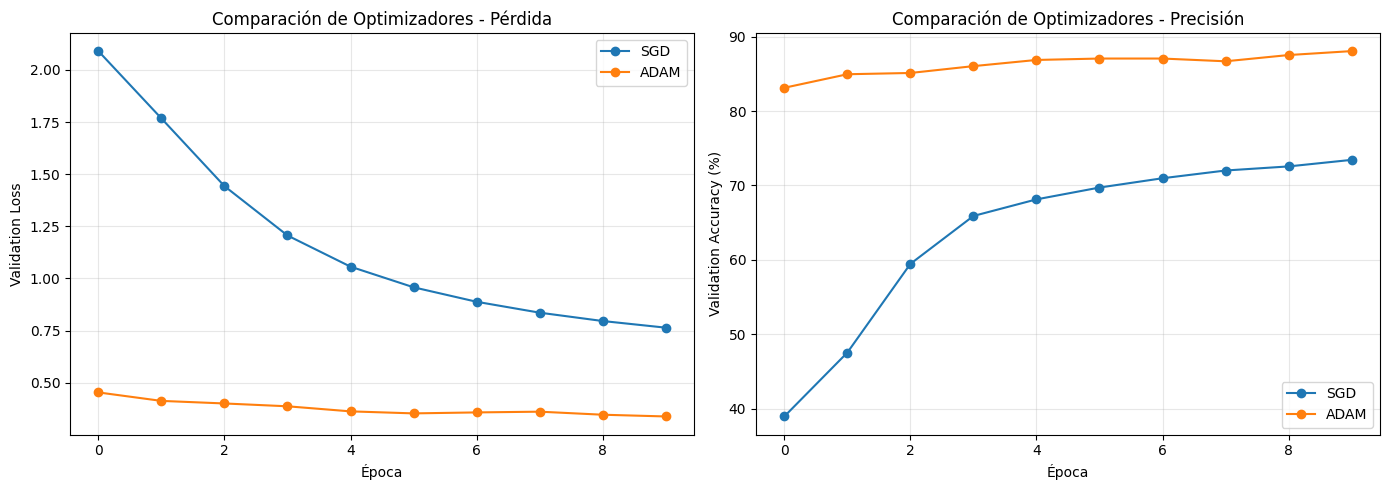

In [34]:
# Comparar SGD vs ADAM
optimizers_config = {
    'SGD': torch.optim.SGD,
    'ADAM': torch.optim.Adam
}

results_opt = {}

for opt_name, opt_class in optimizers_config.items():
    print(f'\nEntrenando con {opt_name}...')
    
    # Reinicializar modelo
    model = FashionMNIST_Net()
    model.to(device)
    
    # Configurar optimizador
    optimizer = opt_class(model.parameters(), lr=0.001)
    
    # Listas para métricas
    train_losses_opt = []
    val_losses_opt = []
    train_accs_opt = []
    val_accs_opt = []
    
    # Entrenar por 10 épocas
    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, valid_loader, criterion, device)
        
        train_losses_opt.append(train_loss)
        val_losses_opt.append(val_loss)
        train_accs_opt.append(train_acc)
        val_accs_opt.append(val_acc)
    
    results_opt[opt_name] = {
        'train_losses': train_losses_opt,
        'val_losses': val_losses_opt,
        'train_accs': train_accs_opt,
        'val_accs': val_accs_opt
    }
    
    print(f'Final - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

# Visualizar comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for opt_name in optimizers_config.keys():
    ax1.plot(results_opt[opt_name]['val_losses'], label=opt_name, marker='o')
    ax2.plot(results_opt[opt_name]['val_accs'], label=opt_name, marker='o')

ax1.set_xlabel('Época')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Comparación de Optimizadores - Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Época')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Comparación de Optimizadores - Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparacion_optimizadores.png', dpi=150, bbox_inches='tight')
plt.show()



---

## Sección 9: Generación de Figuras Finales

### 9.1: Entrenar modelo final con mejores hiperparámetros



In [35]:
# Seleccionar mejores hiperparámetros basado en análisis previo
# Resultados del análisis:
# - ADAM: 88.06% validation accuracy (mejor que SGD: 73.44%)
# - Learning Rate 0.001: óptimo con ADAM
# - 30 épocas: mejor resultado (79.63%)
# - Batch size 32: mejor resultado (79.35%)

best_lr = 0.001  # Óptimo con ADAM
best_optimizer = 'ADAM'  # Mejor rendimiento: 88.06% vs 73.44% de SGD
optimal_epochs = 30  # Mejor resultado: 79.63% validation accuracy
optimal_batch_size = 32  # Mejor resultado: 79.35% validation accuracy

# Crear DataLoaders con batch size óptimo
train_loader_optimal = torch.utils.data.DataLoader(
    train_set, batch_size=optimal_batch_size, shuffle=True
)
valid_loader_optimal = torch.utils.data.DataLoader(
    valid_set, batch_size=optimal_batch_size, shuffle=True
)

# Reinicializar modelo
model_final = FashionMNIST_Net()
model_final.to(device)

# Configurar optimizador final
if best_optimizer == 'ADAM':
    optimizer_final = torch.optim.Adam(model_final.parameters(), lr=best_lr)
else:
    optimizer_final = torch.optim.SGD(model_final.parameters(), lr=best_lr)

# Listas para métricas finales
train_losses_final = []
train_accuracies_final = []
val_losses_final = []
val_accuracies_final = []

print(f'Entrenando modelo final con configuración óptima:')
print(f'  Optimizador: {best_optimizer}')
print(f'  Learning Rate: {best_lr}')
print(f'  Batch Size: {optimal_batch_size}')
print(f'  Épocas: {optimal_epochs}')
print('-' * 60)

for epoch in range(optimal_epochs):
    train_loss, train_acc = train_epoch(
        model_final, train_loader_optimal, criterion, optimizer_final, device
    )
    val_loss, val_acc = validate(
        model_final, valid_loader_optimal, criterion, device
    )
    
    train_losses_final.append(train_loss)
    train_accuracies_final.append(train_acc)
    val_losses_final.append(val_loss)
    val_accuracies_final.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'Época [{epoch+1}/{optimal_epochs}] - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

print('\nEntrenamiento final completado!')
print(f'Precisión final en validación: {val_accuracies_final[-1]:.2f}%')

Entrenando modelo final con configuración óptima:
  Optimizador: ADAM
  Learning Rate: 0.001
  Batch Size: 32
  Épocas: 30
------------------------------------------------------------
Época [5/30] - Train Acc: 86.81%, Val Acc: 86.80%
Época [10/30] - Train Acc: 88.29%, Val Acc: 87.47%
Época [15/30] - Train Acc: 89.25%, Val Acc: 88.17%
Época [20/30] - Train Acc: 89.81%, Val Acc: 87.86%
Época [25/30] - Train Acc: 90.22%, Val Acc: 88.44%
Época [30/30] - Train Acc: 90.68%, Val Acc: 87.99%

Entrenamiento final completado!
Precisión final en validación: 87.99%


### 9.2: Generar figuras finales



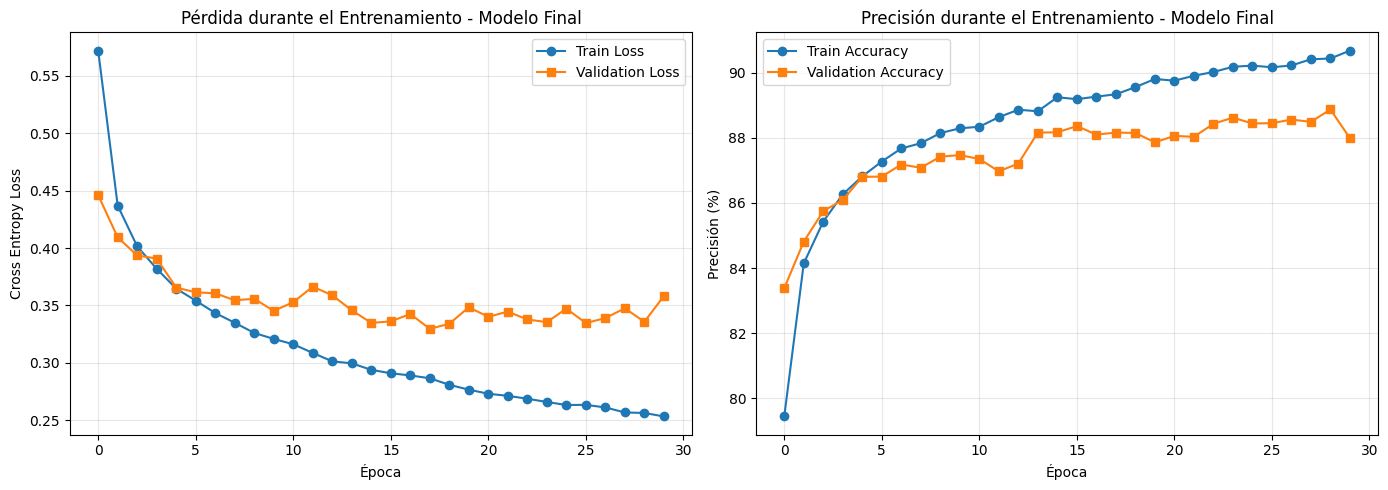

In [36]:
# Curvas de entrenamiento finales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses_final, label='Train Loss', marker='o')
ax1.plot(val_losses_final, label='Validation Loss', marker='s')
ax1.set_xlabel('Época')
ax1.set_ylabel('Cross Entropy Loss')
ax1.set_title('Pérdida durante el Entrenamiento - Modelo Final')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accuracies_final, label='Train Accuracy', marker='o')
ax2.plot(val_accuracies_final, label='Validation Accuracy', marker='s')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión (%)')
ax2.set_title('Precisión durante el Entrenamiento - Modelo Final')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/curvas_entrenamiento_final.png', dpi=150, bbox_inches='tight')
plt.show()



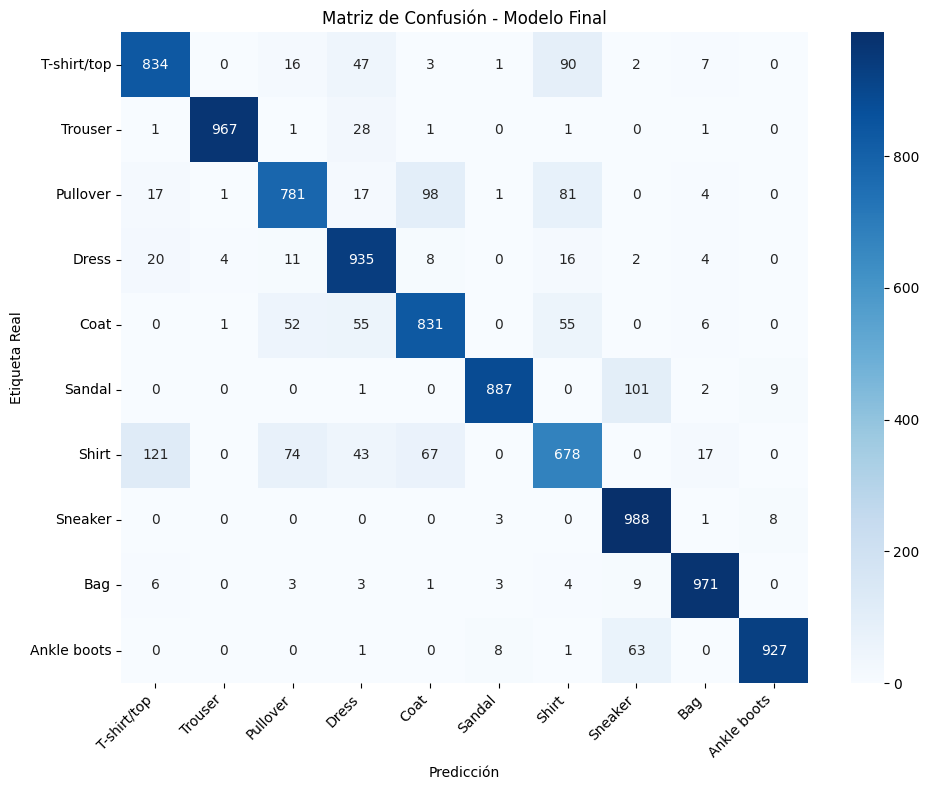

Precisión final en validación: 87.99%


In [37]:
# Matriz de confusión final
model_final.eval()
all_preds_final = []
all_labels_final = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_final(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds_final.extend(predicted.cpu().numpy())
        all_labels_final.extend(labels.cpu().numpy())

# Calcular matriz de confusión
cm_final = confusion_matrix(all_labels_final, all_preds_final)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_names[i] for i in range(10)],
            yticklabels=[class_names[i] for i in range(10)])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión - Modelo Final')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('images/matriz_confusion_final.png', dpi=150, bbox_inches='tight')
plt.show()

# Calcular precisión final
accuracy_final = accuracy_score(all_labels_final, all_preds_final)
print(f'Precisión final en validación: {accuracy_final*100:.2f}%')

